# CIFAR10 Image Classification using Keras 简洁版

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.noise import GaussianNoise
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import numpy as np
import matplotlib.pyplot as plt
from time import time
from keras.utils import to_categorical
from utils import make_parallel, accuracy_curve
%matplotlib inline

nb_classes = 10
class_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck',
}

Using TensorFlow backend.


## 数据预处理：Mean Subtraction Per Channel

In [2]:
def mean_subtraction(data):
    [mean_r, mean_g, mean_b] = np.mean(data, axis=(0,1,2))
    data[:, :, :, 0] -= mean_r
    data[:, :, :, 1] -= mean_g
    data[:, :, :, 2] -= mean_b
    
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.reshape(y_train.shape[0])
y_test = y_test.reshape(y_test.shape[0])
y_train = to_categorical(y_train, nb_classes)
y_test = to_categorical(y_test, nb_classes)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
mean_subtraction(X_train)
mean_subtraction(X_test)
X_train /= 255
X_test /= 255

## 创建模型：基于VGG16简化

In [13]:
def create_model():
    
    x = Input(shape=(32, 32, 3))
    y = x
    y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
    y = Convolution2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
    y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

    y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
    y = Convolution2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
    y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

    y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
    y = Convolution2D(filters=256, kernel_size=3, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(y)
    y = MaxPooling2D(pool_size=2, strides=2, padding='same')(y)

    y = Flatten()(y)
    y = Dropout(0.5)(y)
    y = Dense(units=nb_classes, activation='softmax', kernel_initializer='he_normal')(y)

    model = Model(inputs=x, outputs=y)

    model.summary()

    model = make_parallel(model, 2)

    model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])
    
    return model

## 定义训练过程

1. **可以选择是否使用数据增强**。
2. **使用Early Stopping回调**：监测指标为 val_acc（注：实际上用 val_loss 更好，因为可以在过拟合前及时停止训练）
3. **使用自动保存性能提升模型的回调**：只记录性能得到提升的训练代模型。每次训练都将训练代模型放在一个文件夹内，方便管理
4. **使用Tensoboard回调**：可以自动在Tensorboard上对性能指标绘图，方便后期对比模型。

In [14]:
import os
from datetime import datetime

def train(model, batch, epoch, data_augmentation=True):
    start = time()
    log_dir = datetime.now().strftime('model_%Y%m%d_%H%M')
    os.mkdir(log_dir)
    
    es = EarlyStopping(monitor='val_acc', patience=20)
    mc = ModelCheckpoint(log_dir + '\\CIFAR10-EP{epoch:02d}-ACC{val_acc:.4f}.h5', 
                         monitor='val_acc', save_best_only=True)
    tb = TensorBoard(log_dir=log_dir, histogram_freq=0)
    
    if data_augmentation:
        aug = ImageDataGenerator(width_shift_range = 0.125, height_shift_range = 0.125, horizontal_flip = True)
        aug.fit(X_train)
        gen = aug.flow(X_train, y_train, batch_size=batch)
        h = model.fit_generator(generator=gen, 
                                 steps_per_epoch=50000/batch, 
                                 epochs=epoch, 
                                 validation_data=(X_test, y_test),
                                 callbacks=[es, mc, tb])
    else:
        start = time()
        h = model.fit(x=X_train, 
                      y=y_train, 
                      batch_size=batch, 
                      epochs=epoch, 
                      validation_data=(X_test, y_test),
                      callbacks=[es, mc, tb])
    
    print('\n@ Total Time Spent: %.2f seconds' % (time() - start))
    acc, val_acc = h.history['acc'], h.history['val_acc']
    m_acc, m_val_acc = np.argmax(acc), np.argmax(val_acc)
    print("@ Best Training Accuracy: %.2f %% achieved at EP #%d." % (acc[m_acc] * 100, m_acc + 1))
    print("@ Best Testing Accuracy: %.2f %% achieved at EP #%d." % (val_acc[m_val_acc] * 100, m_val_acc + 1))
    return h

In [12]:
model1 = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 8, 8, 128)         0         
__________

## 训练模型：Batch Size = 64

Epoch 1/200
782/781 [==============================] - 18s - loss: 1.6196 - acc: 0.4136 - val_loss: 1.2328 - val_acc: 0.5514
Epoch 2/200
782/781 [==============================] - 17s - loss: 1.1634 - acc: 0.5847 - val_loss: 1.1631 - val_acc: 0.6021
Epoch 3/200
782/781 [==============================] - 18s - loss: 0.9466 - acc: 0.6673 - val_loss: 0.7904 - val_acc: 0.7256
Epoch 4/200
782/781 [==============================] - 18s - loss: 0.8163 - acc: 0.7162 - val_loss: 0.8244 - val_acc: 0.7137
Epoch 5/200
782/781 [==============================] - 18s - loss: 0.7205 - acc: 0.7520 - val_loss: 0.6976 - val_acc: 0.7654
Epoch 6/200
782/781 [==============================] - 18s - loss: 0.6574 - acc: 0.7725 - val_loss: 0.6195 - val_acc: 0.7880
Epoch 7/200
782/781 [==============================] - 18s - loss: 0.5986 - acc: 0.7920 - val_loss: 0.7246 - val_acc: 0.7607
Epoch 8/200
782/781 [==============================] - 17s - loss: 0.5590 - acc: 0.8075 - val_loss: 0.6350 - val_acc: 0.7864


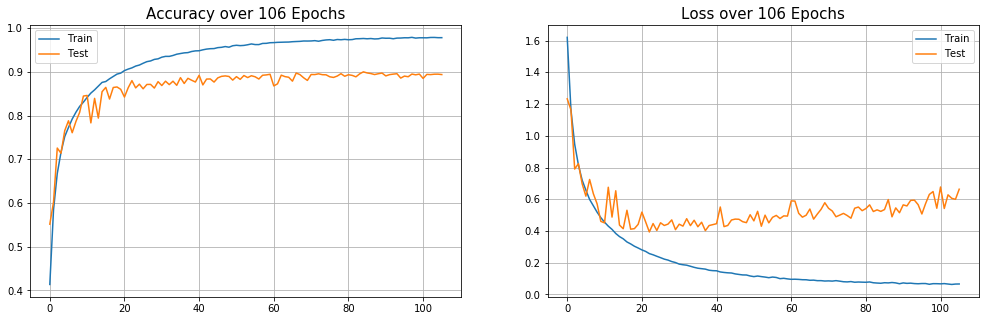

In [5]:
epoch = 200
batch = 64

h = train(model1, batch, epoch)
accuracy_curve(h)

## 分析

- 根据上面的 accuracy 曲线，我们可以看到模型在测试集上所能达到的最高准确度为90%，这一准确度在第85代训练达到。

- 但是根据上面的 loss 曲线，可以观察到模型在第40代训练之后 `loss` 不断上升，这说明模型已经进入过拟合状态，不应再继续训练。

- 结合上面的分析，batch size为64的模型实际收敛准确度应该是 88%-89%。

## 训练模型：Batch Size = 128

In [15]:
model2 = create_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 8, 8, 128)         0         
__________

Epoch 1/200
391/390 [==============================] - 12s - loss: 1.7231 - acc: 0.3762 - val_loss: 1.4053 - val_acc: 0.4891
Epoch 2/200
391/390 [==============================] - 11s - loss: 1.3003 - acc: 0.5352 - val_loss: 1.0433 - val_acc: 0.6291
Epoch 3/200
391/390 [==============================] - 11s - loss: 1.0774 - acc: 0.6208 - val_loss: 0.9539 - val_acc: 0.6599
Epoch 4/200
391/390 [==============================] - 12s - loss: 0.9320 - acc: 0.6747 - val_loss: 0.8397 - val_acc: 0.7176
Epoch 5/200
391/390 [==============================] - 11s - loss: 0.8276 - acc: 0.7118 - val_loss: 0.7632 - val_acc: 0.7322
Epoch 6/200
391/390 [==============================] - 11s - loss: 0.7534 - acc: 0.7385 - val_loss: 0.6606 - val_acc: 0.7683
Epoch 7/200
391/390 [==============================] - 11s - loss: 0.6962 - acc: 0.7587 - val_loss: 0.6774 - val_acc: 0.7700
Epoch 8/200
391/390 [==============================] - 11s - loss: 0.6464 - acc: 0.7753 - val_loss: 0.6291 - val_acc: 0.7836


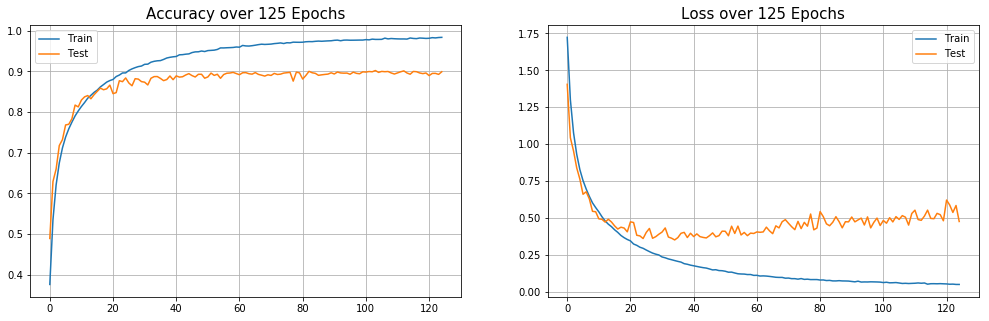

In [16]:
epoch = 200
batch = 128

h = train(model2, batch, epoch)
accuracy_curve(h)

## 分析

- 根据上面的 accuracy 曲线，我们可以看到模型在测试集上所能达到的最高准确度为90.22%，这一准确度在第104代训练达到。

- 但是根据上面的 loss 曲线，可以观察到模型在第60代训练之后 `loss` 不断上升，这说明模型已经进入过拟合状态，不应再继续训练。

- 结合上面的分析，batch size为128的模型实际收敛准确度应该是 89%。

## 总结

使用相同的模型，分辨实验不同的batch size，将模型训练过程用Tensorboard记录绘制如下，可以清晰的看到不同模型在训练过程中的性能差异。

![image](https://github.com/mtyylx/Resources/blob/master/CNN%20-%20Batch%20Size%20vs%20Accuracy%20%26%20Loss.png?raw=true)